In [6]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
import re, string
import sys
import time
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
np.random.seed(2018)
from nltk.corpus import stopwords
nltk.download('wordnet')
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from gensim.models import Word2Vec
import pandas as pd
from keras.models import Sequential, Model
from keras.layers import *
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np


def readData(filename):
    news = pd.read_csv(filename,encoding='latin-1')
    df = news
    print("length of dataset", len(df))
    print('Unique Headlines Categories: {}'.format(len(df.headline_category.unique())))
    df.headline_category = df.headline_category.apply(lambda x: x.split(".")[0]) 
    df = df[df['headline_text'].apply(lambda x: len(x) > 20)]
    df = df.reset_index(drop=True)
    df['index'] = df.index
    # df.describe()
    # read only headlines with length >20
    return df

def save_model(model):
    # serialize model to JSON
    model_json = model.to_json()
    with open('cnnlstmmodel6.json', "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights('cnnlstmmodel6.h5')

def load_model():
    json_file = open('cnnlstmmodel6.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights('cnnlstmmodel6.h5')
    loaded_model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc']) #the accuracy is calculated as the average across all timesteps.
    return loaded_model

text_header = 'preprocess'
labels_header = 'Label'
df = readData('Sentiment_business_labelled_new.csv')
print(df.head())
df=df.dropna(subset=['Label'])
df=df.dropna(subset=['preprocess'])
df = df.reset_index(drop=True)
#code to select equal number of positive, negative and neutral rows to make the dataset more balanced.
df_p=(df[df['Label']=="Positive"])
df_p = df_p.sample(n=350)
df_n=(df[df['Label']=="Negative"])
df_n = df_n.sample(n=350)
df_ne=(df[df['Label']=="Neutral"])
df = pd.concat([df_p,df_n,df_ne])

df['index'] = df.index
## Tokenize words of input data to form word index and sequences to prepare for word embeddings
MAX_NB_WORDS = 20000#max(len(c) for c in df[text_header])#df[text_header].map(len).max()
print("Max len =", df[text_header].map(len).max()) #172

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(df[text_header])
sequences = tokenizer.texts_to_sequences(df[text_header])

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

MAX_SEQUENCE_LENGTH = max(len(c) for c in sequences)
print('max seq len = ', MAX_SEQUENCE_LENGTH) #9

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape) #(1332078, 11)


## Split train and validation
indices = np.arange(data.shape[0])
VALIDATION_SPLIT = 0.4

#labels = pd.get_dummies(df[labels_header],prefix=[labels_header]) #one hot encoding
labels = pd.get_dummies(df.Label).values
#print('labels shape =', np.shape(labels))

labels_index = df[labels_header].unique()
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=0)
sss.get_n_splits(data, labels)
for train_index, test_index in sss.split(data, labels):
    x_train = data[[train_index]]
    y_train = labels[[train_index]]
    x_test_full = data[[test_index]]
    y_test_full = labels[[test_index]]
    #x_train, x_test = df['preprocess'].train_index, df['preprocess'].test_index
    #y_train, y_test = y[train_index], y[test_index]
    
print(len(y_train),len(y_test_full))

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=0)
sss.get_n_splits(x_test_full, y_test_full)
for train_index, test_index in sss.split(x_test_full, y_test_full):
    x_test = x_test_full[[train_index]]
    y_test = y_test_full[[train_index]]
    x_val = x_test_full[[test_index]]
    y_val = y_test_full[[test_index]]
    #x_train, x_test = df['preprocess'].train_index, df['preprocess'].test_index
    #y_train, y_test = y[train_index], y[test_index]
    
print(len(y_test),len(y_val))
## train embedding layer
#embedding_layer = Embedding(len(word_index) + 1,
#                             EMBEDDING_DIM,
#                             input_length=MAX_SEQUENCE_LENGTH)
embeddings_index = {}
f = open('/Users/pguttula/Desktop/old_mac/CS578/SML_project/midterm/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

EMBEDDING_DIM = 100
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
nb_labels = 3
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False))
## use embedding with GLoVe dictionary


model.add(Conv1D(128, 5, activation='relu', data_format='channels_first'))
model.add(MaxPooling1D(5))
model.add(Conv1D(128, 5, activation='relu', data_format='channels_first'))
model.add(MaxPooling1D(5))
model.add(Conv1D(128, 5, activation='relu', data_format='channels_first'))
model.add(MaxPooling1D(5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
#model.add(Bidirectional(LSTM(100, return_sequences=True)))
#model.add(Bidirectional(LSTM(100, return_sequences=True)))
#model.add(Bidirectional(LSTM(100)))
#model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
epochs = 1
batch_size = 64
print(np.shape(y_train),np.shape(y_val),np.shape(y_test))
## train model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=50, batch_size=128)

save_model(model)


##Accuracies with 70 epochs-new labels-training accuracy 

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/pguttula/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/Users/pguttula/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:109: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/pguttula/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:110: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/pguttula/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:111: FutureWarning: Using a non-tuple sequence for multidimensional indexing 

length of dataset 1999
Unique Headlines Categories: 1
   Unnamed: 0  publ headline_category  \
0      156246  1999          business   
1       68730  1997          business   
2      391235  2003          business   
3      439414  2004          business   
4      611770  2007          business   

                                       headline_text  index  \
0        Treasury plans Â£50m electricity investment      0   
1  Sahota urges Mackie investors to back Â£5.2 mi...      1   
2  Has Martin got the metal for Herculean task at...      2   
3                  Bord Gais may build power station      3   
4  ICG's Dublin Port site will not deliver 'windf...      4   

                                          preprocess     Label  
0                        treasuri plan electr invest  Positive  
1  sahota urg macki investor million right issu v...   Neutral  
2                   martin metal herculean task elan   Neutral  
3                       bord gai build power station   Neutr

670/670 [==============================] - 2s 3ms/step - loss: 0.0184 - accuracy: 0.9955 - val_loss: 2.5974 - val_accuracy: 0.4911
Epoch 50/50
670/670 [==============================] - 1s 1ms/step - loss: 0.0178 - accuracy: 0.9955 - val_loss: 2.6047 - val_accuracy: 0.4866


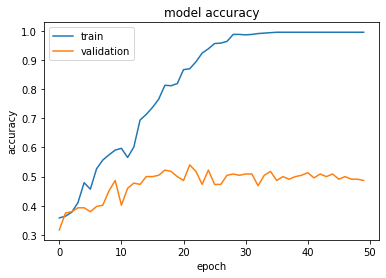

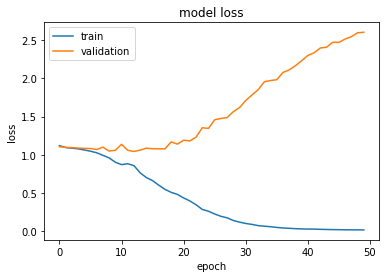

224
{0, 1, 2}
{0, 1, 2}
224
0.5580357142857143


In [10]:
# summarize history for accuracy
# summarize history for accuracy
import matplotlib.pyplot as plt
plt.figure(0)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('accuracy_cnn_task2_50_new.png',bbox_inches='tight')
plt.show()
plt.close()
# summarize history for loss
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('loss_cnn_task2_new.png',bbox_inches='tight')
plt.show()
plt.close()


# model = Word2Vec(df['headline_text'], size=100, window=5, min_count=5, workers=16, sg=0, negative=5)
# word_vectors = model.wv

y_pred = model.predict(x_test)
def getmax(y_pred):
    prediction = []
    for i in y_pred:
        prediction.append(list(i).index(max(i)))
    return prediction
prediction = getmax(y_pred)
print(len(prediction))
print(set(prediction))
def getindex(y):
    prediction = []
    for i in y:
        #print(i)
        if max(list(i))==1:
            prediction.append((list(i).index(1)))
        else:
            prediction.append(0)
    return prediction
t_prediction = getindex(y_test)
print(set(t_prediction))
print(len(t_prediction))
def accuracy(y_test,prediction):
    c=0
    for i in range(len(prediction)):
        if y_test[i] == prediction[i]:
            c+=1
    return c
counts = accuracy(t_prediction,prediction)
print(float(counts/len(prediction)))